In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression as linreg
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import KFold
from itertools import combinations

## Ex. 7.9

In [2]:
predictors = pd.read_csv('./data/prostate', sep=' ', index_col=0)
train = predictors.pop('train')
response = predictors.pop('lpsa')
predictors = predictors.apply(zscore)

X_train = predictors[train == 'T'].values
y_train = response[train == 'T'].values
X_test = predictors[train == 'F'].values
y_test = response[train == 'F'].values

d = X_train.shape[1]

In [3]:
def subset(k):
    aic = np.inf
    subset_aic = None
    bic = np.inf
    subset_bic = None
    
    cross5 = np.inf
    subset_cross5 = None
    cross10 = np.inf
    subset_cross10 = None
    
    for cols in combinations(range(d), k):
        reg = OLS(y_train, add_constant(X_train[:, cols])).fit()
        if reg.aic < aic:
            aic = reg.aic
            subset_aic = cols
            
        if reg.bic < bic:
            bic = reg.bic
            subset_bic = cols
        
        score5 = 0
        for train, validation in KFold(n_splits=5).split(X_train):
            reg = linreg().fit(X_train[:, cols][train].reshape([-1, len(cols)]), y_train[train])
            y_hat = reg.predict(X_train[:, cols][validation].reshape([-1, len(cols)]))
            score5 += np.mean((y_hat - y_train[validation]) ** 2)
            
        score10 = 0
        for train, validation in KFold(n_splits=10).split(X_train):
            reg = linreg().fit(X_train[:, cols][train].reshape([-1, len(cols)]), y_train[train])
            y_hat = reg.predict(X_train[:, cols][validation].reshape([-1, len(cols)]))
            score10 += np.mean((y_hat - y_train[validation]) ** 2)
        
        if score5 / 5 < cross5:
            cross5 = score5 / 5
            subset_cross5 = cols
            
        if score10 / 10 < cross10:
            cross10 = score10 / 10
            subset_cross10 = cols
    
    return aic, subset_aic, bic, subset_bic, cross5, subset_cross5, cross10, subset_cross10

best subset (AIC): 7
best subset (BIC): 2
best subset (Cross5): 5
best subset (Cross10): 7


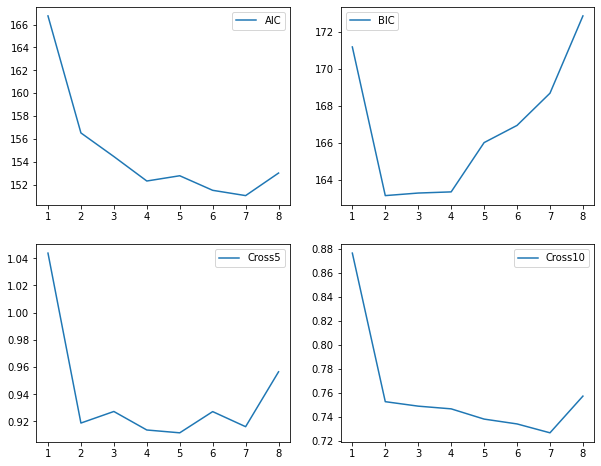

In [4]:
AIC = []
BIC = []
Cross5 = []
Cross10 = []
K = np.arange(1, d + 1)
for k in K:
    aic, subset_aic, bic, subset_bic, cross5, subset_cross5, cross10, subset_cross10 = subset(k)
    AIC.append(aic)
    BIC.append(bic)
    Cross5.append(cross5)
    Cross10.append(cross10)
    
argmin_aic = np.argmin(AIC)
argmin_bic = np.argmin(BIC)
argmin_cross5 = np.argmin(Cross5)
argmin_cross10 = np.argmin(Cross10)
print('best subset (AIC): {}'.format(K[argmin_aic]))
print('best subset (BIC): {}'.format(K[argmin_bic]))
print('best subset (Cross5): {}'.format(K[argmin_cross5]))
print('best subset (Cross10): {}'.format(K[argmin_cross10]))
    
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
axs[0].plot(K, AIC, label='AIC')
axs[1].plot(K, BIC, label='BIC')
axs[2].plot(K, Cross5, label='Cross5')
axs[3].plot(K, Cross10, label='Cross10')
for ax in axs:
    ax.legend()

plt.show()